# Capsule Networks

To understand intuition behind capsule networks follow these blogs: 
1. [Capsule Networks](https://theailearner.com/2019/01/21/capsule-networks/)
2. [Implementing Capsule Network in Keras](https://theailearner.com/2019/01/21/implementing-capsule-network-in-keras/)

## Introduction

A capsule is a group of neurons which uses vectors to represent an object or object part. Length of a vector represents presence of an object and orientation of vector represents its pose(size, position, orientation, etc). Group of these capsules forms a capsule layer and then these layers lead to form a capsule network.

We can break the implementation of capsule network into following steps:

1. Initial convolutional layer
2. Primary capsule layer
3. Digit capsule layer
4. Decoder network
5. Loss Functions
6. Training and testing of model

### Imports

In [1]:
import keras
from keras.models import Model
from keras.layers import Conv2D, Dense, Input, Reshape, Lambda, Layer, Flatten
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
import tensorflow as tf
from keras import initializers
from keras.utils import to_categorical
from keras.layers.core import Activation

Using TensorFlow backend.


### Load MNIST Data

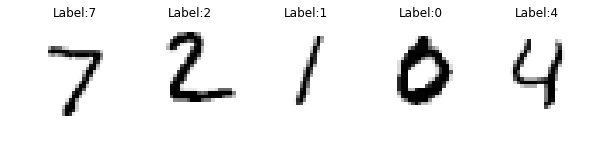

In [2]:
# download training and test data from mnist and reshape it

(x_train, y_orig_train), (x_test, y_orig_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(-1,28,28,1)
y_train = np.array(to_categorical(y_orig_train.astype('float32')))

x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(-1,28,28,1)
y_test = np.array(to_categorical(y_orig_test.astype('float32')))

x_output = x_train.reshape(-1,784)
X_valid_output = x_test.reshape(-1,784)

n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = x_test[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.title("Label:" + str(y_orig_test[index]))
    plt.axis("off")

plt.show()

### Initial Convolution Layer

Initially we will use a convolution layer to detect low level features of an image. It will use 256 filters each of size 9x9 with stride 1 and activation function is relu. Input size of image is 28x28, after applying this layer output size will be 20x20x256.

In [3]:
input_shape = Input(shape=(28,28,1))  # size of input image is 28*28
 
# a convolution layer output shape = 20*20*256
conv1 = Conv2D(256, (9,9), activation = 'relu', padding = 'valid')(input_shape)

### Primary Capsule Layer

The output from the previous layer is being passed to 256 filters each of size 9x9 with a stride of 2 which will produce an output of size 6x6x256. This output is then reshaped into 8-dimensional vector. So shape will be 6x6x32 capsules each of which will be 8-dimensional. Then it will pass through a non-linear function(squash) so that length of output vector can be maintained between 0 and 1.

In [4]:
# convolution layer with stride 2 and 256 filters of size 9*9
conv2 = Conv2D(256, (9,9), strides = 2, padding = 'valid')(conv1)
 
# reshape into 1152 capsules of 8 dimensional vectors
reshaped = Reshape((6*6*32,8))(conv2)
 
def squash(inputs):
    # take norm of input vectors
    squared_norm = K.sum(K.square(inputs), axis = -1, keepdims = True)
 
    # use the formula for non-linear function to return squashed output
    return ((squared_norm/(1+squared_norm))/(K.sqrt(squared_norm+K.epsilon())))*inputs

# squash the reshaped output to make length of vector b/w 0 and 1
squashed_output = Lambda(squash)(reshaped)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


### Digit Capsule Layer

Here we need to write a custom layer in keras. It will take 1152x8 as its input and produces output of size 10x16, where 10 capsules each represents an output class with 16 dimensional vector. Then each of these 10 capsules are converted into single value to predict the output class using a lambda layer.

In [5]:
class DigitCapsuleLayer(Layer):
    # creating a layer class in keras
    def __init__(self, **kwargs):
        super(DigitCapsuleLayer, self).__init__(**kwargs)
        self.kernel_initializer = initializers.get('glorot_uniform')
    
    def build(self, input_shape): 
        # initialize weight matrix for each capsule in lower layer
        self.W = self.add_weight(shape = [10, 6*6*32, 16, 8], initializer = self.kernel_initializer, name = 'weights')
        self.built = True
    
    def call(self, inputs):
        inputs = K.expand_dims(inputs, 1)
        inputs = K.tile(inputs, [1, 10, 1, 1])
        # matrix multiplication b/w previous layer output and weight matrix
        inputs = K.map_fn(lambda x: K.batch_dot(x, self.W, [2, 3]), elems=inputs)
        b = tf.zeros(shape = [K.shape(inputs)[0], 10, 6*6*32])
        
# routing algorithm with updating coupling coefficient c, using scalar product b/w input capsule and output capsule
        for i in range(3-1):
            c = tf.nn.softmax(b, dim=1)
            s = K.batch_dot(c, inputs, [2, 2])
            v = squash(s)
            b = b + K.batch_dot(v, inputs, [2,3])
            
        return v 
    def compute_output_shape(self, input_shape):
        return tuple([None, 10, 16])
    
    
    
def output_layer(inputs):
    return K.sqrt(K.sum(K.square(inputs), -1) + K.epsilon())
 
digit_caps = DigitCapsuleLayer()(squashed_output)
outputs = Lambda(output_layer)(digit_caps)

Instructions for updating:
dim is deprecated, use axis instead


### Decoder Network

To further boost the pose parameters learned by the digit capsule layer, we can add decoder network to reconstruct the input image. In this part, decoder network will be fed with an input of size 10x16 (digit capsule layer output) and will reconstruct back the original image of size 28x28. Decoder will consist of 3 dense layer having 512, 1024 and 784 nodes.

During training time input to the decoder is the output from digit capsule layer which is masked with original labels. It means that other vectors except the vector corresponding to correct label will be multiplied with zero. So that decoder can only be trained with correct digit capsule. In test time input to decoder will be the same output from digit capsule layer but masked with highest length vector in that layer. Lets see the code.

In [6]:
def mask(outputs):
 
    if type(outputs) != list:  # mask at test time
        norm_outputs = K.sqrt(K.sum(K.square(outputs), -1) + K.epsilon())
        y  = K.one_hot(indices=K.argmax(norm_outputs, 1), num_classes = 10)
        y = Reshape((10,1))(y)
        return Flatten()(y*outputs)
 
    else:    # mask at train time
        y = Reshape((10,1))(outputs[1])
        masked_output = y*outputs[0]
        return Flatten()(masked_output)
    
inputs = Input(shape = (10,))
masked = Lambda(mask)([digit_caps, inputs])
masked_for_test = Lambda(mask)(digit_caps)
 
decoded_inputs = Input(shape = (16*10,))
dense1 = Dense(512, activation = 'relu')(decoded_inputs)
dense2 = Dense(1024, activation = 'relu')(dense1)
decoded_outputs = Dense(784, activation = 'sigmoid')(dense2)
decoded_outputs = Reshape((28,28,1))(decoded_outputs)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


### Loss Functions

Now define a probabilistic loss function used for classifying digits image.

In [7]:
def loss_fn(y_true, y_pred):
 
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + 0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))
 
    return K.mean(K.sum(L, 1))

### Training of model

In [8]:
decoder = Model(decoded_inputs, decoded_outputs)
model = Model([input_shape,inputs],[outputs,decoder(masked)])
test_model = Model(input_shape,[outputs,decoder(masked_for_test)])
 
m = 128
epochs = 10
model.compile(optimizer=keras.optimizers.Adam(lr=0.001),loss=[loss_fn,'mse'],loss_weights = [1. ,0.0005],metrics=['accuracy'])
model.fit([x_train, y_train],[y_train,x_train], batch_size = m, epochs = epochs, validation_data = ([x_test, y_test],[y_test,x_test]))
 

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1364s - loss: 0.1678 - lambda_2_loss: 0.1678 - model_1_loss: 0.0869 - lambda_2_acc: 0.8238 - model_1_acc: 0.7991 - val_loss: 0.0248 - val_lambda_2_loss: 0.0247 - val_model_1_loss: 0.0547 - val_lambda_2_acc: 0.9833 - val_model_1_acc: 0.7963
Epoch 2/10
60000/60000 [==============================] - 1357s - loss: 0.0211 - lambda_2_loss: 0.0211 - model_1_loss: 0.0537 - lambda_2_acc: 0.9862 - model_1_acc: 0.7945 - val_loss: 0.0172 - val_lambda_2_loss: 0.0172 - val_model_1_loss: 0.0528 - val_lambda_2_acc: 0.9882 - val_model_1_acc: 0.7926
Epoch 3/10
60000/60000 [==============================] - 1356s - loss: 0.0150 - lambda_2_loss: 0.0150 - model_1_loss: 0.0532 - lambda_2_acc: 0.9907 - model_1_acc: 0.7939 - val_loss: 0.0153 - val_lambda_2_loss: 0.0153 - val_model_1_loss: 0.0528 - val_lambda_2_acc: 0.9885 - val_mod

### Predict from above trained model

In [13]:
label_predicted, image_predicted = model.predict([x_test, y_test])

### Testing of model

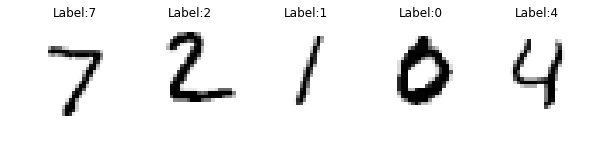

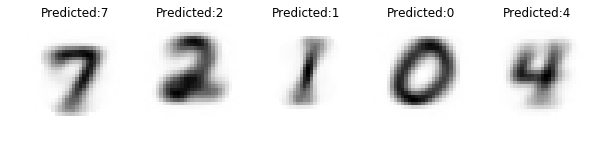

In [14]:
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = x_test[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.title("Label:" + str(y_orig_test[index]))
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = image_predicted[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.title("Predicted:" + str(np.argmax(label_predicted[index])))
    plt.axis("off")

plt.show()